### Importing necessary libraries

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

### Loading MNIST dataset

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 [==============================] - 1s 0us/step


### Generator model
The generator model has the following architecture:
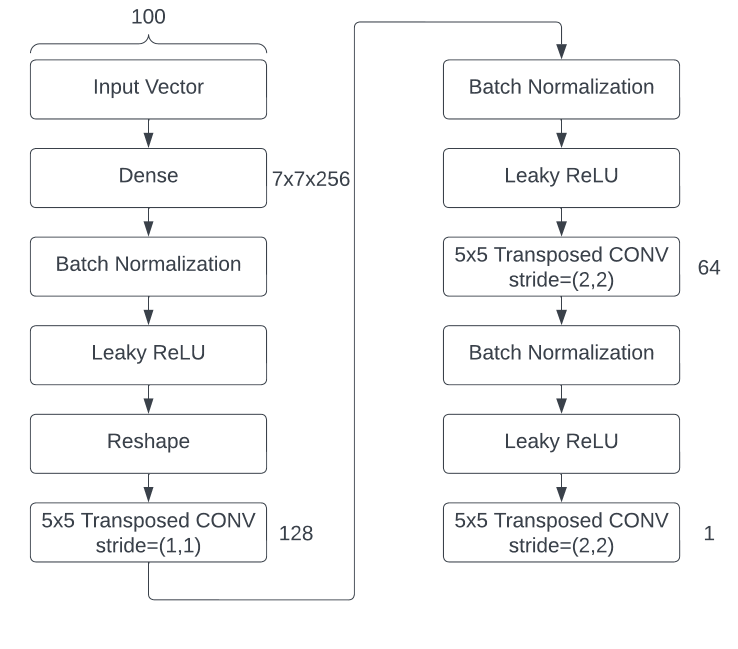

In [ ]:
def make_generator_model():

    ### ↑

    a=layers.Input(shape=(100,))
    x=layers.Dense(7*7*256)(a)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU()(x)
    x=layers.Reshape((7,7,256))(x)
    x=layers.Conv2DTranspose(128, (5,5), strides = (1,1), padding='same')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU()(x)
    x=layers.Conv2DTranspose(64,(5,5), strides = (2,2), padding='same')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU()(x)
    x=layers.Conv2DTranspose(1,(5,5), strides = (2,2), padding='same')(x)

    model = tf.keras.models.Model(inputs=a, outputs=x)

    ### ↓
    return model

### Image generated from the untrained generator

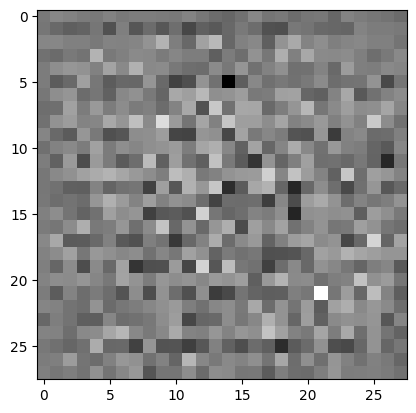

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator model
The discriminator model has the following architecture:
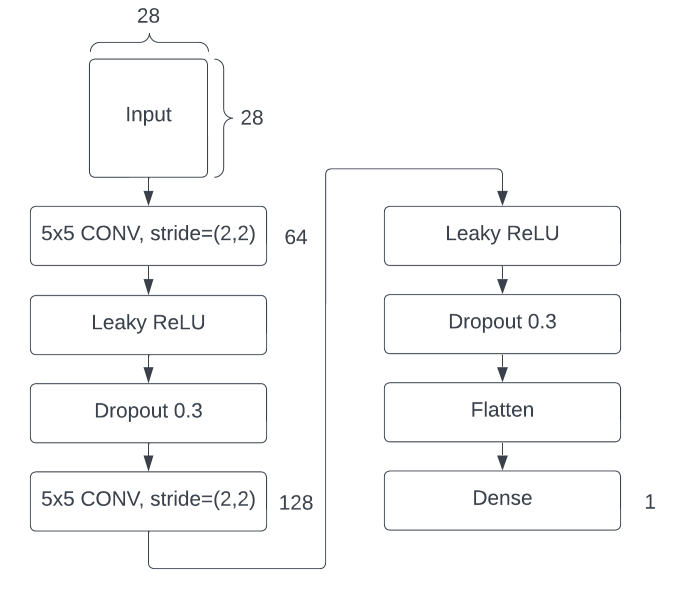

In [ ]:
def make_discriminator_model():
    ### ↑
    a=layers.Input(shape=(28,28,1))
    x=layers.Conv2D(64, (5,5), strides = (2,2))(a)
    x=layers.LeakyReLU()(x)
    x=layers.Dropout(0.3)(x)
    x=layers.Conv2DTranspose(128,(5,5), strides = (2,2))(x)
    x=layers.LeakyReLU()(x)
    x=layers.Dropout(0.3)(x)
    x=layers.Flatten()(x)
    x=layers.Dense(1)(x)
    model = tf.keras.models.Model(inputs=a, outputs=x)
    ### ↓
    return model

### Initial decision on the image

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0002609]], shape=(1, 1), dtype=float32)


### Loss function and optimizer
Come up with loss functions instead of log likelihood that we've learn in the lecture

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    ### ↑
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    ### ↓
    return total_loss

In [ ]:
def generator_loss(fake_output):
    ### ↑
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    ### ↓
    return loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Training loop

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

### Do train

In [ ]:
train(train_dataset, EPOCHS)

Time for epoch 1 is 30.907269954681396 sec
Time for epoch 2 is 19.927350282669067 sec
Time for epoch 3 is 19.64338493347168 sec
Time for epoch 4 is 19.486570358276367 sec
Time for epoch 5 is 19.527471780776978 sec
Time for epoch 6 is 19.628962993621826 sec
Time for epoch 7 is 19.63090467453003 sec
Time for epoch 8 is 19.590988636016846 sec
Time for epoch 9 is 19.582865476608276 sec
Time for epoch 10 is 19.56129503250122 sec
Time for epoch 11 is 19.56709313392639 sec
Time for epoch 12 is 19.646055221557617 sec
Time for epoch 13 is 19.61314582824707 sec
Time for epoch 14 is 19.609984159469604 sec
Time for epoch 15 is 19.619255781173706 sec
Time for epoch 16 is 19.611208200454712 sec
Time for epoch 17 is 19.64359450340271 sec
Time for epoch 18 is 19.61292338371277 sec
Time for epoch 19 is 19.605843544006348 sec
Time for epoch 20 is 19.581275701522827 sec
Time for epoch 21 is 19.58710503578186 sec
Time for epoch 22 is 19.59221386909485 sec
Time for epoch 23 is 19.574671506881714 sec
Time f

### Final images

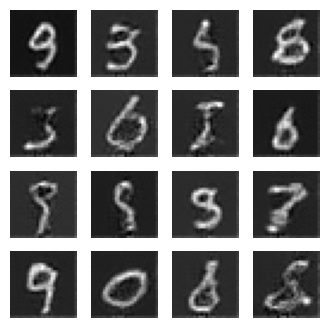

In [ ]:
predictions = generator(seed, training=False)

fig = plt.figure(figsize=(4,4))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.savefig('image.png')
plt.show()